In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from collections import OrderedDict

$\textbf{Exercise 1: Preprocssing}$

In [1]:
data = np.loadtxt("pca2.csv", delimiter = ',', skiprows = 1)

#Perform PCA:

pca1 = PCA(n_components= data.shape[1], svd_solver='full')
pca_data_trans1= pca1.fit_transform(data)

#Plot the data:

def pca_scatter(data):

    plt.figure(figsize = (10,10))
    plt.scatter(data[:,0], data[:,1], c = 'olive')
    #plt.scatter(data[:,0], data[:,1], c = outliers(data))
    plt.title("Principal Components")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.show()

pca_scatter(pca_data_trans1)
pca_scatter(data)

NameError: name 'np' is not defined

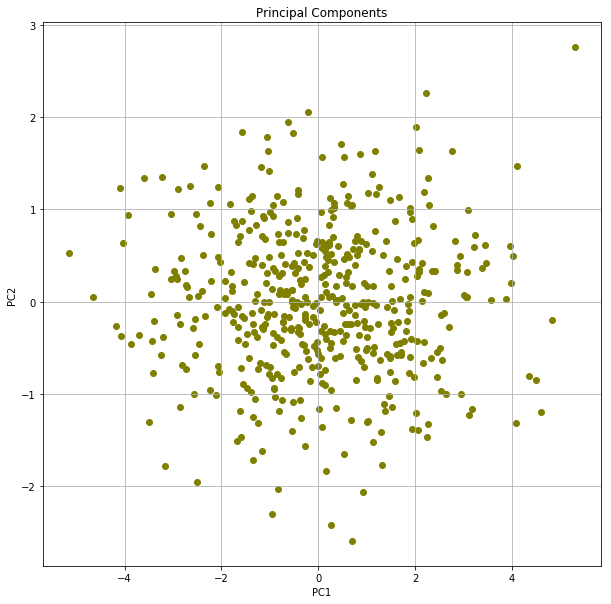

In [88]:
#Part(b):
data_del = np.delete(data, [16,156], axis = 0)

#Repeat PCA:

pca2 = PCA(n_components= data_del.shape[1], svd_solver='full')
pca_data_trans2 = pca2.fit_transform(data_del)


#Plot the data:

pca_scatter(pca_data_trans2)


The difference is that the twop outliers have been removed, so the data now has different elongation and, hence, different PCs.

$\textbf{Exercise 2: Whitening:}$

<Figure size 720x720 with 0 Axes>

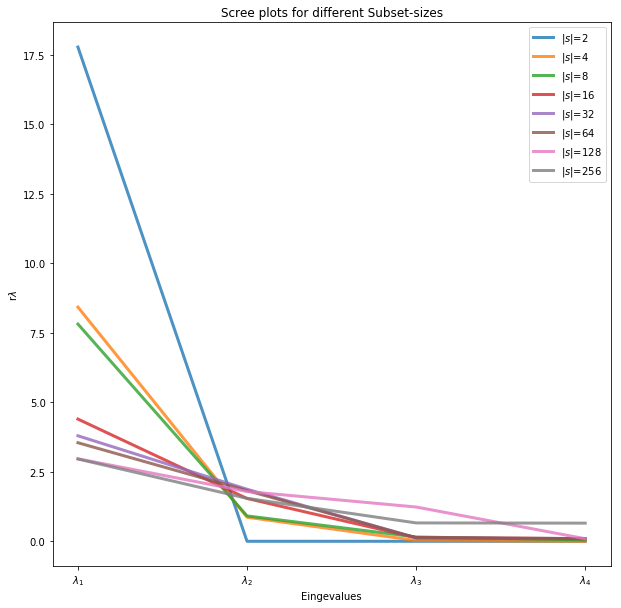

In [89]:
data_w = np.loadtxt("pca4.csv", delimiter = ',', skiprows = 1)

#Plot the data for visual inspection:

plt.figure(figsize = (10,10))

def outliers(data):
    
    """
    Finds all outliers in a data set:
    Outliers are datapoints that are more than 2 standard deviations
    from the mean in either of the two directions. If the data
    follow a normal distribution this would make about 5% of the data 
    points outliers, which we think is reasonable
    @params:
    data_w: the data
    """
    
    sigma, mu = data.std(), data.mean()
    outliers = np.zeros(data.shape[0], dtype = bool)
    
    for pI, point in np.ndenumerate(data):
        
        if np.any((point - mu) > 2 * sigma):
            
            outliers[pI[0]] = True
    
    return outliers 

#Weed out the outliers:

data_w = data_w[~outliers(data_w)]

#Manual version of PCA:

def pca(data):
    
    #Creating OrderedDict to hold the values:
    
    result = OrderedDict()
    
    #Solve the eigenvalue problem:
    
    result["evals"], result["evecs"] = np.linalg.eig(np.cov(data.T))
    
    #Return data in new basis:
    #Since evecs is orthonormalbasis we have evecs.T = Inv(evecs):

    result["new_data"] = result["evecs"].T @ data.T
    
    return result


def iterate_pca (data, epsilon, start_value = 2):
    
    """
    Recursive procedure that produces a scree plot
    @params:
    data: the data
    start_value: the value with which to start the iteration
    epsilon: the cutoff criterion for the distance between eigenvalues
    
    """
    k = start_value 
    
    fig, ax = plt.subplots(figsize = (10,10))
    
    while k < data.shape[0]:
        
        eigenvals = pca(data[:k])["evals"]
    
        eigenvals.sort() 
        

        ax.set_xticks(np.arange(len(eigenvals)))
        labels = [r"$\lambda_{}$".format(i+1) for i in range(eigenvals.shape[0])]
        ax.set_xticklabels(labels)
        
        ax.plot(np.arange(len(eigenvals)), eigenvals[::-1], alpha = .8, linewidth = 3, label = r"$|s|$={}".format(k)) 
        ax.set_title("Scree plots for different Subset-sizes")
        ax.set_xlabel("Eingevalues")
        ax.set_ylabel("r$\lambda$")
        ax.legend()
        
        k = k * 2
            
        
iterate_pca(data_w, 2)

Here we can see that above a subset-size of 32, the result no longer changes in any intresting way. Mostly the plots seem to reveal that two to three PCS represent the data reasonably well.

$\textbf{Part[c + d]: Whiten the data}$

(4, 437)


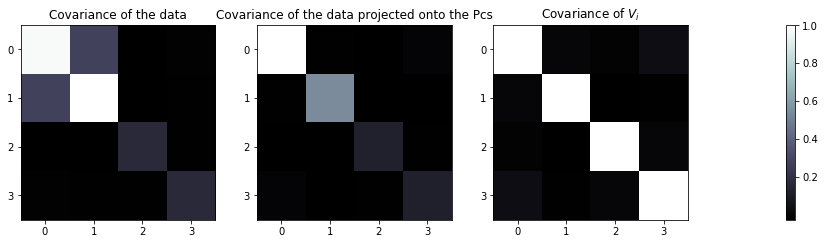

In [125]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def whiten(data):
    
    pca_res = pca(data)
    
    C = np.cov(data.T)
    L = np.linalg.inv(np.sqrt(np.diag(pca_res["evals"])))
    M = pca_res["evecs"].T
    
    #Center the data:
    X = (data - data.mean(axis=0)).T
    
    result = L @ M.T @ X
    print(result.shape)
    
    #Part (d):
    
    fig, axs = plt.subplots(1,3, figsize = (10,10))
    
    
    plt.tight_layout()
    
    axins = inset_axes(axs[2],
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.5, 0, 1, 1),
                   bbox_transform=axs[2].transAxes,
                   borderpad=0,
                   )
    
    axs[0].imshow(C, cmap = 'bone')
    axs[0].set_title("Covariance of the data")
    axs[0].set_yticks(np.arange(4))
    
    axs[1].imshow(np.cov(M.T @ X), cmap = 'bone')
    axs[1].set_title("Covariance of the data projected onto the Pcs")
    axs[1].set_yticks(np.arange(4))
    
    im3=axs[2].imshow(np.cov(result), cmap = 'bone')
    axs[2].set_title(r"Covariance of $V_i$")
    axs[2].set_yticks(np.arange(4))
    fig.colorbar(im3, cax=axins, ticks=[.2,.4,.6,.8,1])
    
    
    return result

whitened_data = whiten(data_w).T


The first image shows the Covariance matrix of the data themselves. We can see that the data, as we predicted from looking at the scree plots, vary almost entirely in two dimensions. This is confirmed in the middle image. The righmost plot contains the whitened data. We can see that they are completely decorrelated with variance one.